# Homework 1 - Question 2

Imports

In [1]:
import pandas as pd
import pyarrow.parquet as pq
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
# inline plot
%matplotlib inline
# default figure size
matplotlib.rcParams['figure.figsize'] = (20, 10)
# to make our sets reproducible
np.random.seed(42)
%config Completer.use_jedi = False

In [2]:
from pathlib import Path
from typing import Tuple

#### Read the Data

In [3]:
data_path = Path('..') / 'data' / 'data2.parquet'
t = pq.read_table(data_path, memory_map=True)
df = t.to_pandas()

#### First Impressions - basic visual analysis of the data

Some basic statistics on the data:

In [4]:
df.describe()

,x,y
count,100.000000,100.000000
mean,5.000000,12.247093
std,2.930454,3.277851
min,0.000000,2.636535
25%,2.500000,10.073236
50%,5.000000,11.579393
75%,7.500000,14.248710
max,10.000000,21.000932


There is a clear increase in the variance of $y$ as $x$ increases:

<AxesSubplot:xlabel='x', ylabel='y'>

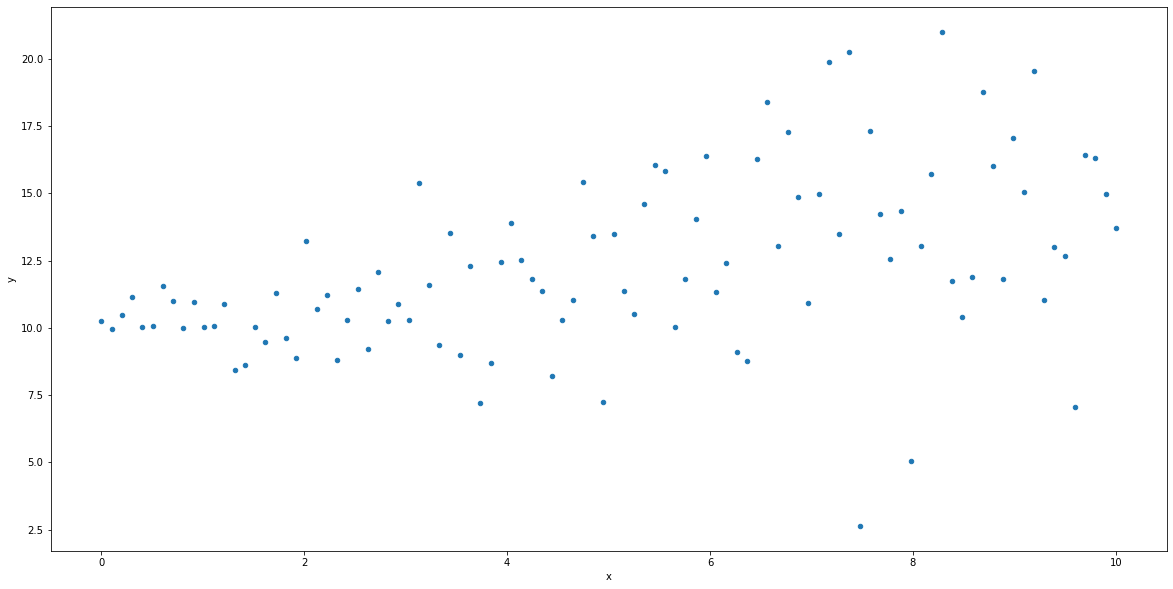

In [5]:
df.plot.scatter(x='x', y='y')

Extract $X$ and $y$ into arrays:

In [6]:
X = df.x.values.reshape(-1, 1)
y = df.y.values

### Linear Regression

First, let us find out what a simple linear regression produces:

In [7]:
from sklearn.linear_model import LinearRegression
# include intercept
lin_reg = LinearRegression(fit_intercept=True)
lin_reg.fit(X, y)
lin_reg.intercept_, lin_reg.coef_

(9.675209482951814, array([0.51437679]))

Plot the linear function - obtained from linear regression, along with the data

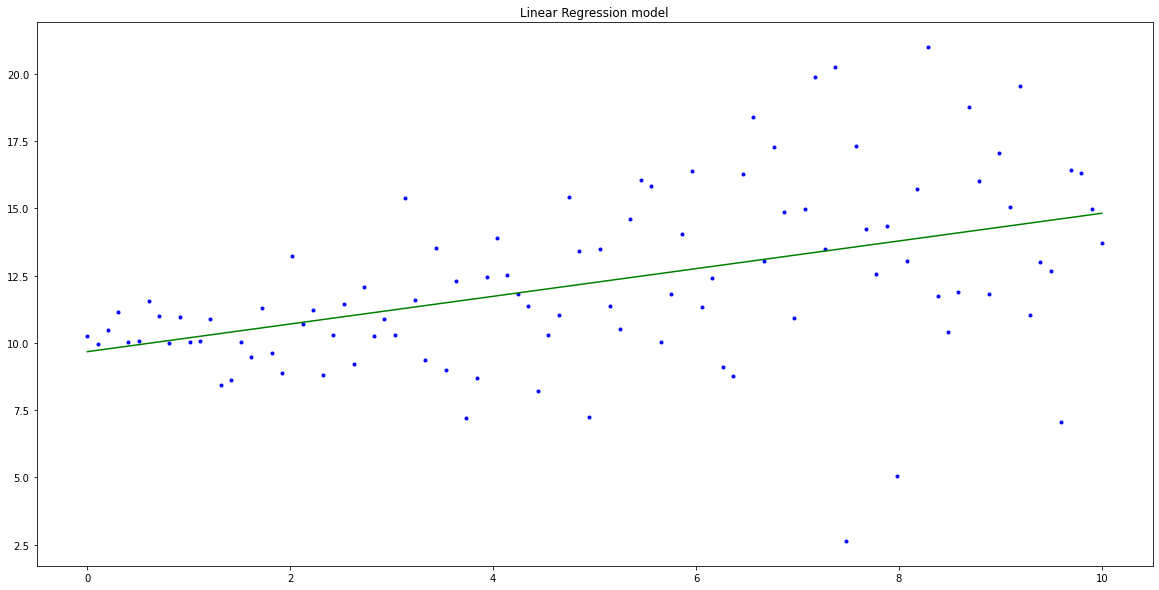

In [8]:
plt.plot(X, y, "b.")

xs = np.linspace(int(X.min()), int(X.max()), 100)[:, np.newaxis]
ys = lin_reg.predict(xs)
plt.plot(xs, ys, "g-", label='fit')
plt.title('Linear Regression model')

plt.show()

#### Let us check if linear regression assumptions hold true:

##### First, we analyze the 'Residuals vs. Fitted' plot:

Text(0.5, 1.0, 'Residuals vs. Fitted')

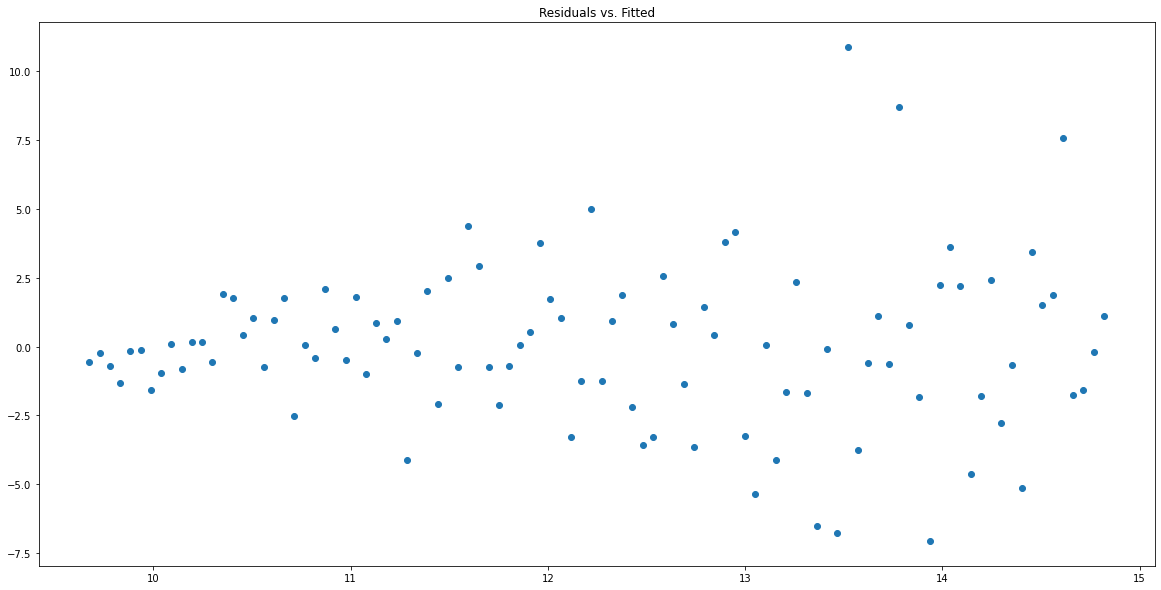

In [9]:
y_predicted = lin_reg.predict(X)

residuals = y_predicted - y
plt.scatter(x=y_predicted, y=residuals)
plt.title('Residuals vs. Fitted')

There is a funnel-shaped pattern evident in the 'Residuals vs. Fitted' scatter plot. This suggests non-constant variance, that is, Heteroskedasticity.

In [10]:
from statsmodels.stats.stattools import durbin_watson
durbin_watson(residuals)

2.18685668141106

We see that the Durbin - Watson (DW) statistic is > 2 and < 4. Which indicates there is a negative autocorrelation.

Let us analyze the Normal Quantile-Quantile (Q-Q) plot:

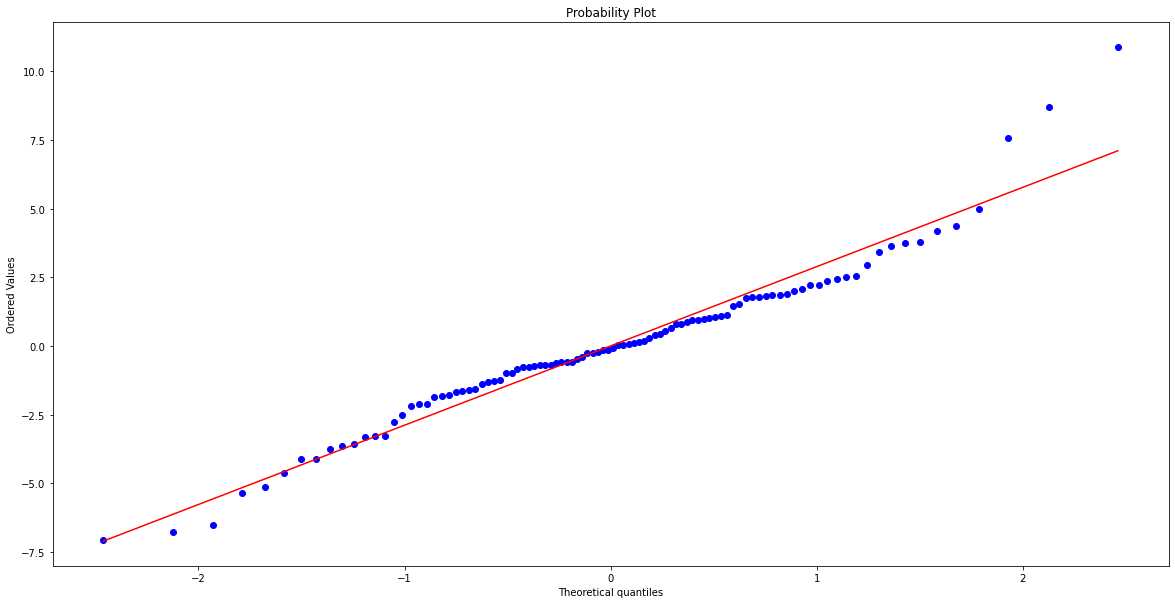

In [11]:
from scipy.stats import probplot

_ = probplot(residuals, plot=plt)

This looks not as normal as we'd like, especially in the higher and lower "theoretical quantiles".

#### We conclude that the residuals do not admit linear regression assumptions.

Let us model the data using quantile regression.

### Quantile Regression

In [12]:
import statsmodels.formula.api as smf

quant_reg = smf.quantreg(formula='y ~ x', data=df)

Let us model quantile regression on the data with quantiles in 0.05, 0.5 and 0.95

In [13]:
q_5 = quant_reg.fit(q=0.05)
q_median = quant_reg.fit(q=0.5)
q_95 = quant_reg.fit(q=0.95)

print(q_5.summary())
print(q_median.summary())
print(q_95.summary())

                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squared:              0.04929
Model:                       QuantReg   Bandwidth:                       4.316
Method:                 Least Squares   Sparsity:                        16.25
Date:                Sat, 20 Nov 2021   No. Observations:                  100
Time:                        14:35:29   Df Residuals:                       98
                                        Df Model:                            1
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      9.1829      0.781     11.759      0.000       7.633      10.733
x             -0.3945      0.122     -3.229      0.002      -0.637      -0.152
                         QuantReg Regression Results                          
Dep. Variable:                      y   Pseudo R-squ

Now, let us compare the results with linear regression and analyze them visually:

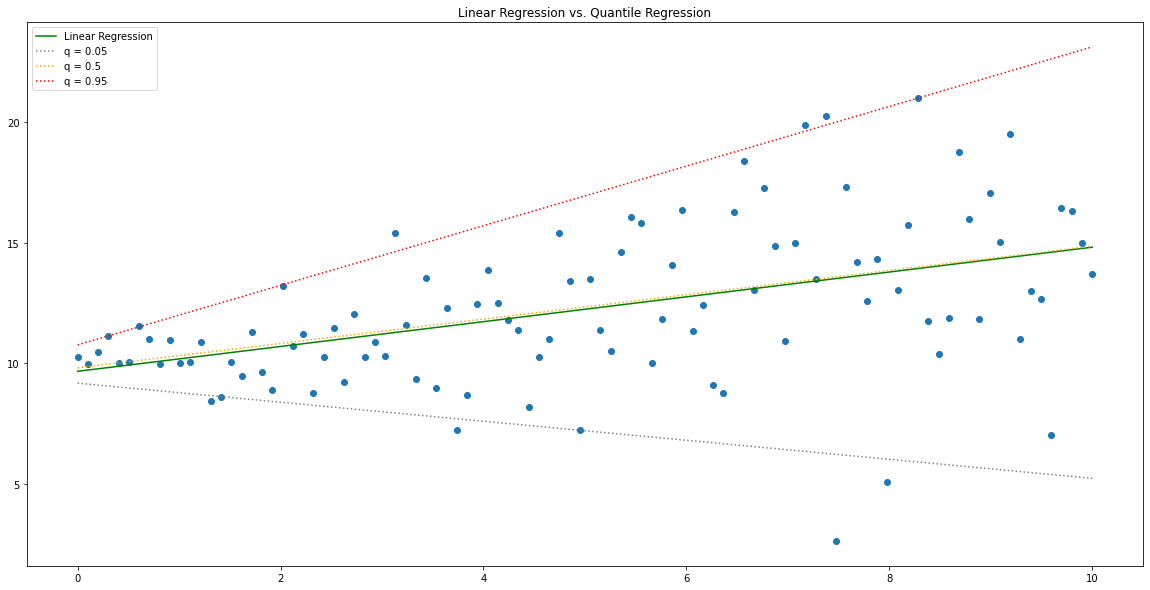

In [14]:
plt.scatter(X, y)

xs = np.linspace(int(X.min()), int(X.max()), 100)[:, np.newaxis]

ys_lin = lin_reg.predict(xs)

ys_quan_5 = q_5.params['Intercept'] + q_5.params['x'] * xs
ys_quan_median = q_median.params['Intercept'] + q_median.params['x'] * xs
ys_quan_95 = q_95.params['Intercept'] + q_95.params['x'] * xs

plt.plot(xs, ys, "g-", label='Linear Regression')

plt.plot(xs, ys_quan_5, linestyle='dotted', color='grey', label='q = 0.05')
plt.plot(xs, ys_quan_median, linestyle='dotted', color='orange', label='q = 0.5')
plt.plot(xs, ys_quan_95, linestyle='dotted', color='red', label='q = 0.95')

plt.title('Linear Regression vs. Quantile Regression')
plt.legend(loc='best')

plt.show()

Some conclusions from the plots:
1. For low quantiles - y decreases with x (negative slope). For high quantiles - y increases with x (positive slope).
2. The dispersion of y increases with x.
3. The linear regression estimate is very close to the median quantile estimate.

The other interesting visualization is slope values and their upper/lower bounds (confidence intervals) for different quantiles:

First, let us use the statsmodels package to model the data with least squares (linear regression) and extract upper/lower bounds of confidence levels.

In [15]:
ols = smf.ols('y ~ x', df).fit()
ols_lb, ols_ub = ols.conf_int().loc['x'].tolist()
ols_intercept = ols.params['Intercept']
ols_coeff = ols.params['x']

# just make sure - sanity check
assert np.allclose(ols_intercept, lin_reg.intercept_)
assert np.allclose(ols_coeff, lin_reg.coef_)

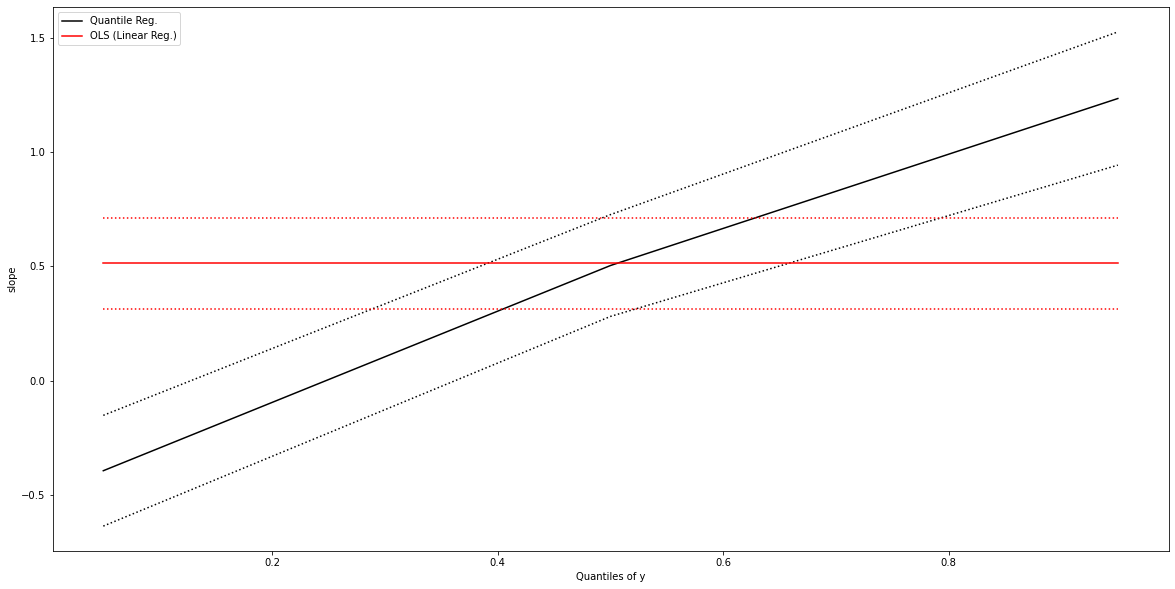

In [16]:
qs = [0.05, 0.5, 0.95]

q_5_lb, q_5_ub = q_5.conf_int().loc["x"].tolist()
q_median_lb, q_median_ub = q_median.conf_int().loc["x"].tolist()
q_95_lb, q_95_ub = q_95.conf_int().loc["x"].tolist()

plt.plot(qs, [q_5.params['x'], q_median.params['x'], q_95.params['x']], color="black", label="Quantile Reg.")
plt.plot(qs, [q_5_lb, q_median_lb, q_95_lb], color="black", linestyle="dotted")
plt.plot(qs, [q_5_ub, q_median_ub, q_95_ub], color="black", linestyle="dotted")
plt.plot(qs, [ols_coeff] * len(qs), color="red", label="OLS (Linear Reg.)")
plt.plot(qs, [ols_lb] * len(qs), linestyle="dotted", color="red")
plt.plot(qs, [ols_ub] * len(qs), linestyle="dotted", color="red")
plt.ylabel(r"slope")
plt.xlabel("Quantiles of y")
plt.legend()
plt.show()

The above plot shows the variation of slope across different quantiles and comparison with ordinary linear regression, which is flat across all the quantiles.

In most cases, the quantile regression point estimates lie outside the OLS confidence interval, which suggests that the effect of x on y may not be constant across the distribution.

#### Quantile Regression - what is it?

Standard linear regression uses the method of least squares (or MSE) to calculate the conditional mean of $y$ across different values of $x$.
Quantile regression is an extension of Standard linear regression, which estimates the conditional median (which is the 50th quantile, as well as other quantiles) of $y$
and can be used when assumptions of linear regression are not met (i.e., linearity, homoscedasticity, independence, or normality).

##### Fitting Quantile Regression models:

The standard linear regression model for the conditional mean of $y$ is:
$MSE = \frac{1}{n} \cdot \sum_{i=1}^n (y_i - \beta^\intercal \cdot x_i)$

In contrast, the regression model for quantile level $\tau$ of $y$ is:
$MAD = \sum_{i=1}^n \rho_{\tau} (y_i - \beta(\tau)^\intercal \cdot x_i)$
where $\beta(\tau)$ is now a function of the quantile parameter $\tau$ and $\rho_{\tau}(r) = \tau \cdot \operatorname{max}(r, 0) + (1 - \tau) \cdot \operatorname{max}(-r, 0)$ is referred to as the check loss, as its shape resembles a check mark.

#### Quantile Regression - when to use it?

1. To estimate the median, or the 0.25 quantile, or any quantile
2. Key assumption of linear regression is not satisfied
3. Outliers in the data
4. residuals are not normal
5. Increase in error variance with increase in outcome variable